In this workflow I would like to test to average a HiC file. I am not sure if I would transform it into a mcool file or just a bedpe... 

In [1]:
# Init libraries
import cooler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import warnings

scaler = StandardScaler()

# Global variables
in_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12/2023_12_19/Results/"
out_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12/2023_12_19/Results/"

# Local functions

#Function to filter ids appearing in less than n cell types
def filter_ids(df,n_cells=5, column='count'):
    # count the number of elements per id
    tmp = df.groupby('id')[column].count()
    # ids of intereaction appearing in n cell types
    ids = tmp[tmp == n_cells].index
    # filter the data
    df = df[df['id'].isin(ids)]
    
    # histogram of interaction in less than n cell types
    plt.hist(tmp[tmp < n_cells], bins=10)
    plt.title(f"Distribution of Interaction IDs with Less than {n_cells} Elements\nColumn: {column}")
    plt.xlabel("Number of Elements")
    plt.ylabel("Frequency")
    plt.show()
    
    return df

# Function to replace NaN values with a value outside the range of the data
def replace_nan(df, column='scaled', replace_with=-10):
        
    #if the value is true, throw a warning and change the nan_value to something more appropriate
    if data['scaled'].min() < replace_with:
        # Change the value based on the minimum value of the scaled data
        replace_with = round(data['scaled'].min() - 1)  
        warnings.warn(f"The replace_with is not outside the range of the scaled data. Changing the value to: {nan_value}")
        
    # replace the NaN values with the nan_value
    df[column] = df[column].fillna(replace_with)
    
    return df


In [2]:
#let's load the data
data = pd.read_csv(in_dir + "scaled_matrix_1000000.csv")
data[:5]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced,cell_type,log10_balanced,scaled
0,chr1,0,1000000,chr1,0,1000000,16844,0.138459,GM12878,-0.858680,3.507877
1,chr1,0,1000000,chr1,1000000,2000000,3148,0.038244,GM12878,-1.417435,2.531712
2,chr1,0,1000000,chr1,2000000,3000000,332,0.004826,GM12878,-2.316379,0.961228
3,chr1,0,1000000,chr1,3000000,4000000,228,0.002806,GM12878,-2.551865,0.549825
4,chr1,0,1000000,chr1,4000000,5000000,128,0.001592,GM12878,-2.797943,0.119919


I need to average the scaled data for each interaction.
Then, I need to add an interaction_id, then group by interaction (or loop by interaction) to average the scaled data.
This can be a bit time consuming for high resolution bins.

In [3]:
# add interaction id
data['id'] = data['chrom1'] + '_' + data['start1'].astype(str) + '_' + data['chrom2'] + '_' + data['start2'].astype(str)
data[:5]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced,cell_type,log10_balanced,scaled,id
0,chr1,0,1000000,chr1,0,1000000,16844,0.138459,GM12878,-0.858680,3.507877,chr1_0_chr1_0
1,chr1,0,1000000,chr1,1000000,2000000,3148,0.038244,GM12878,-1.417435,2.531712,chr1_0_chr1_1000000
2,chr1,0,1000000,chr1,2000000,3000000,332,0.004826,GM12878,-2.316379,0.961228,chr1_0_chr1_2000000
3,chr1,0,1000000,chr1,3000000,4000000,228,0.002806,GM12878,-2.551865,0.549825,chr1_0_chr1_3000000
4,chr1,0,1000000,chr1,4000000,5000000,128,0.001592,GM12878,-2.797943,0.119919,chr1_0_chr1_4000000


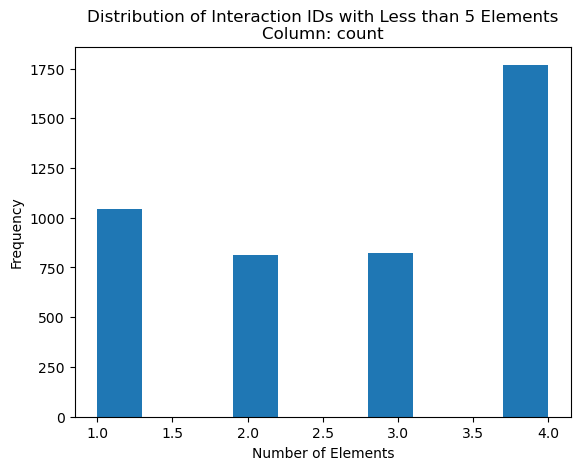

In [4]:
# In a previous test, we found that there are some interactions that doesn't appear in all cell types
# This interactions can be filtered out as we want to focus on housekeeping interactions

#Filter interactions that doesn't appear in all cell types
data = filter_ids(data, n_cells=5, column='count')

In [5]:
# In a previous test, I found that there are some NaN values in the scaled data
# This NaN could create a bias in the mean values. 
# To avoid this, I will replace the NaN values with a value outside the range of the data
# I coded a function to do this
data = replace_nan(data, column='scaled', replace_with=-10)
data['scaled'].isna().sum()

0

In [6]:
#Then, we can calculate the mean values 

# group by id and calculate mean of scaled interaction
mean_values = data.groupby('id')['scaled'].mean()
mean_values[:5]


id
chr10_0_chr10_0            4.039282
chr10_0_chr10_1000000      2.836969
chr10_0_chr10_10000000     0.617643
chr10_0_chr10_100000000   -0.421057
chr10_0_chr10_101000000   -0.465298
Name: scaled, dtype: float64

In [7]:
# now, using the ids I need to create a new dataframe with the chroms and positions
# we can filter the data for only one cell type and remove the unnecessary columns
data_mean = data[data['cell_type'] == "GM12878"].copy()
# select only the columns we need
data_mean = data_mean[['id', 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
data_mean[:5]

,id,chrom1,start1,end1,chrom2,start2,end2
0,chr1_0_chr1_0,chr1,0,1000000,chr1,0,1000000
1,chr1_0_chr1_1000000,chr1,0,1000000,chr1,1000000,2000000
2,chr1_0_chr1_2000000,chr1,0,1000000,chr1,2000000,3000000
3,chr1_0_chr1_3000000,chr1,0,1000000,chr1,3000000,4000000
4,chr1_0_chr1_4000000,chr1,0,1000000,chr1,4000000,5000000


In [8]:
# We want to pass the information from mean_values to data_mean

# First, we need to convert mean_values to a DataFrame and reset its index
# Convert mean_values to a DataFrame and reset its index
mean_values = mean_values.reset_index()
# Also rename the columns 
mean_values.columns = ['id', 'mean']
# Finally, merge the dataframes using the id column as anchor between them
data_mean = data_mean.merge(mean_values, on='id', how='left')
data_mean[:5]

,id,chrom1,start1,end1,chrom2,start2,end2,mean
0,chr1_0_chr1_0,chr1,0,1000000,chr1,0,1000000,3.686164
1,chr1_0_chr1_1000000,chr1,0,1000000,chr1,1000000,2000000,2.551184
2,chr1_0_chr1_2000000,chr1,0,1000000,chr1,2000000,3000000,1.022731
3,chr1_0_chr1_3000000,chr1,0,1000000,chr1,3000000,4000000,0.514062
4,chr1_0_chr1_4000000,chr1,0,1000000,chr1,4000000,5000000,0.054296


In [9]:
# Save the data with mean values
data_mean.to_csv(out_dir + "mean_values.tsv", index=False, header=True, sep='\t')

In [164]:
## TEST 3. 
# On these blocks I will test how can I pass the information from mean_values to data_mean 
# Some of these tests are still unclear to me, but I am getting a better idea of how python works

# I want to pass the information from mean_values to data_mean

#for testing
test_mean = mean_values.copy()
test_mean = test_mean.reindex(data_mean['id'])

# Convert mean_values to a DataFrame and reset its index
mean_values = mean_values.reset_index()
# rename the columns 
mean_values.columns = ['id', 'mean']
print(mean_values[:5])
print(test_mean[:5])

                        id      mean
0          chr10_0_chr10_0  4.039282
1    chr10_0_chr10_1000000  2.836969
2   chr10_0_chr10_10000000  0.617643
3  chr10_0_chr10_100000000 -0.421057
4  chr10_0_chr10_101000000 -0.465298
id
chr1_0_chr1_0          3.686164
chr1_0_chr1_1000000    2.551184
chr1_0_chr1_2000000    1.022731
chr1_0_chr1_3000000    0.514062
chr1_0_chr1_4000000    0.054296
Name: scaled, dtype: float64


In [121]:
#short tests before merging the information
#same number of rows
print(len(data_mean) == len(mean_values))

#same ids 
# check if all elements in "id" column are in the index of mean_values
all_in_index = data_mean['id'].isin(mean_values.index).all()
print(all_in_index)
print(data_mean['id'].equals(mean_values.index))

True
True
False


In [122]:
# Sort data_mean by 'id'
data_mean = data_mean.sort_values('id')

# Convert mean_values to a DataFrame and reset its index
mean_values_df = mean_values.reset_index()

# Sort mean_values_df by 'id'
mean_values_df = mean_values_df.sort_values('id')

# Now check if 'id' values are the same and in the same order
# print(data_mean['id'].equals(mean_values_df['id']))

False


In [ ]:


# order the mean_values using the ids of data_mean
mean_values = mean_values.reindex(data_mean['id'])
mean_values[:5]

# compare the ids with the mean_values index
data_mean['id'].equals(mean_values.index.values)

# add the new mean column
# data_mean['mean'] = mean_values.values
# data_mean[:5]

# mean_values = mean_values.sort_index(
# mean_values[:5]


# add the new mean column
# data_mean['mean'] = mean_values.values
# data_mean[:5]



<AxesSubplot: >

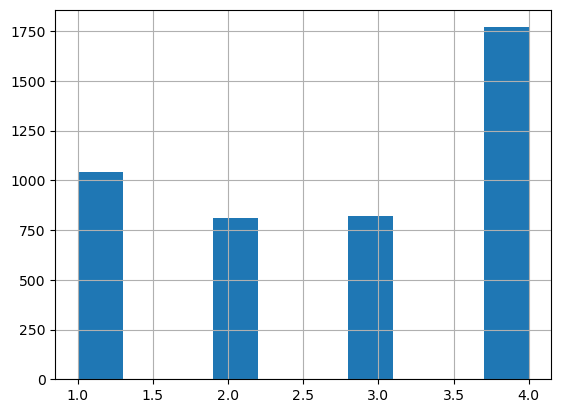

In [45]:
# TEST 1.
# It looks like I have different number of bins by cell type.
# This is causing problems when trying to find the average values of the scaled interactions.
# I would like to see how many bins are common and how many are cell type specific.

#Let's cound the number of data related to each bin. I would expect most to have 5 elements as we have 5 cell types.
tmp = data.groupby('id')['count'].count()

#let's see how many bins have less than 5 elements
tmp[tmp < 5].count()

#there are 4445 elements with less than 5. There are 224656 elements in total (4445/224656 = 0.0198)
#Most of the bins have 5 elements. 

#let's see th4e distribution of the number of bins for those with are less than 5
tmp[tmp < 5].hist()

In [64]:
# as we want to focus on housekeeping interactions, we will only keep those bins that have 5 elements
# let's create a function to keep only interaction ids found in all cell types
def filter_ids(df,n_cells=5, column='count'):
    # count the number of elements per id
    tmp = df.groupby('id')[column].count()
    # ids of intereaction appearing in n cell types
    ids = tmp[tmp == n_cells].index
    # filter the data
    df = df[df['id'].isin(ids)]
    
    # histogram of interaction in less than n cell types
    plt.hist(tmp[tmp < n_cells], bins=10)
    plt.title(f"Distribution of Interaction IDs with Less than {n_cells} Elements\nColumn: {column}")
    plt.xlabel("Number of Elements")
    plt.ylabel("Frequency")
    plt.show()
    
    return df
    


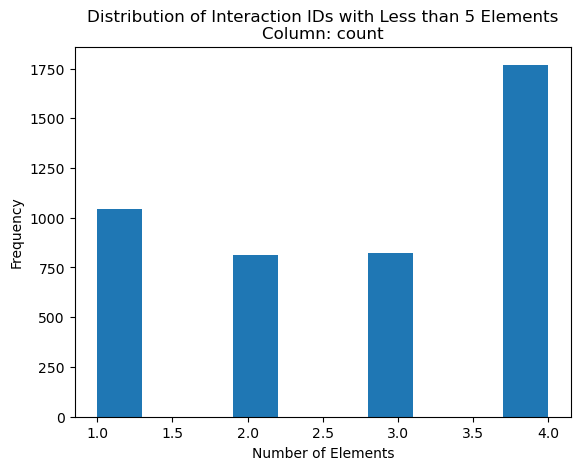

0

In [65]:
#let's test the function
test_data = filter_ids(data, n_cells=5, column='count')

sum(test_data.groupby('id')['count'].count() < 5)

#yay, it works! For keep the record, I would like to print a histogram showing the distribution of the filtered ids.

In [57]:
#TEST 2.
# I want to deal with the NaN values in the scaled data. As the mean value will ignore this NaN values
# They will create a bias in the mean value. I would like to replace the NaN values with a value outside of the range
# of the scaled data. I can use the value of -10 for example, as an arbitrary large negative value.
# However, I need to verify that this is actually outside of the range of the scaled data.
# If not, I need to throw a warning and change the value to something else.

print(data['scaled'].min())

#let's define an arbitrary large negative value
nan_value = -1

# let's check the range of the scaled data
data['scaled'].min()

#let's compare with the value of -10
data['scaled'].min() < nan_value

#if the value is true, then we need to throw a warning and change the value to something else
if data['scaled'].min() < nan_value:
    # Change the value based on the minimum value of the scaled data
    nan_value = round(data['scaled'].min() - 1)  
    warnings.warn(f"The nan_value is not outside the range of the scaled data. Changing the value to: {nan_value}")
    
#let's create a function to replace the NaN values with the nan_value
def replace_nan(df, column='scaled', replace_with=-10):
        
    #if the value is true, throw a warning and change the nan_value to something more appropriate
    if data['scaled'].min() < replace_with:
        # Change the value based on the minimum value of the scaled data
        replace_with = round(data['scaled'].min() - 1)  
        warnings.warn(f"The replace_with is not outside the range of the scaled data. Changing the value to: {nan_value}")
        
    # replace the NaN values with the nan_value
    df[column] = df[column].fillna(replace_with)
    
    return df

-3.7115573891535303


/var/folders/ny/ghryq2s96nd28p5hz1bzc4240000gn/T/ipykernel_35847/3414352897.py:23: UserWarning: The nan_value is not outside the range of the scaled data. Changing the value to: -5
  warnings.warn(f"The nan_value is not outside the range of the scaled data. Changing the value to: {nan_value}")


In [69]:
#let's test the function

#test data
test_data1 = data.copy()
#replace NaN values
test_data2 = replace_nan(test_data1.copy(), column='scaled', replace_with=-10)
# data['scaled'].isna().sum()
#print NaN values before replacing
print(data['scaled'].isna().sum())
print(test_data1['scaled'].isna().sum())
print(test_data2['scaled'].isna().sum())

# I need to be careful for things I want to keep to send a copy of the data and not the data itself
# Anyway, the function works as expected. Let's apply it to the data

43489
43489
0
